# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [4]:
print('The dataset represents 17 campaigns.')

REFERENCE="""
The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.
During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. 
For each contact, a large number of attributes was stored (e.g. see Table 2) and if there was a success (the target variable). 
For the whole database considered, there were 6499 successes (8% success rate).
"""

The dataset represents 17 campaigns.


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time

from sklearn.metrics import recall_score, confusion_matrix,ConfusionMatrixDisplay


import seaborn as sns
import matplotlib.pyplot as plt

from joblib import parallel_backend

In [8]:
#df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

## this full file is for the final run.
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

## the below small file is used to test the models, and then switch to the full file for the final run.
#df = pd.read_csv('data/bank-additional.csv', sep = ';')

In [9]:
#df.head()
df.info()
df[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [14]:
## WE will drop the values for contact=cellular and only keep the record for contact=telephone, becauese this is the requirement.
df = df[df['contact'] == 'telephone']

# Drop columns with too many missing values (e.g., more than 30%)
threshold = 0.3  # 30% missing values threshold
df_telephone = df.dropna(thresh=len(df) * threshold, axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15044 entries, 0 to 41171
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             15044 non-null  int64  
 1   job             15044 non-null  object 
 2   marital         15044 non-null  object 
 3   education       15044 non-null  object 
 4   default         15044 non-null  object 
 5   housing         15044 non-null  object 
 6   loan            15044 non-null  object 
 7   contact         15044 non-null  object 
 8   month           15044 non-null  object 
 9   day_of_week     15044 non-null  object 
 10  duration        15044 non-null  int64  
 11  campaign        15044 non-null  int64  
 12  pdays           15044 non-null  int64  
 13  previous        15044 non-null  int64  
 14  poutcome        15044 non-null  object 
 15  emp.var.rate    15044 non-null  float64
 16  cons.price.idx  15044 non-null  float64
 17  cons.conf.idx   15044 non-null  floa

In [16]:
## drop the duration column because the duration is not known before a call is performed.
df = df.drop(columns=['duration'])

df.sample()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
5414,37,blue-collar,single,unknown,unknown,no,no,telephone,may,fri,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15044 entries, 0 to 41171
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             15044 non-null  int64  
 1   job             15044 non-null  object 
 2   marital         15044 non-null  object 
 3   education       15044 non-null  object 
 4   default         15044 non-null  object 
 5   housing         15044 non-null  object 
 6   loan            15044 non-null  object 
 7   contact         15044 non-null  object 
 8   month           15044 non-null  object 
 9   day_of_week     15044 non-null  object 
 10  campaign        15044 non-null  int64  
 11  pdays           15044 non-null  int64  
 12  previous        15044 non-null  int64  
 13  poutcome        15044 non-null  object 
 14  emp.var.rate    15044 non-null  float64
 15  cons.price.idx  15044 non-null  float64
 16  cons.conf.idx   15044 non-null  float64
 17  euribor3m       15044 non-null  floa

In [96]:
print("""
Business objective of The task 
1. Build a model to train and predict the campaign results before make the telephone call. 
2. In the case we have only limited resource, or we want to provide better service for these who mostly accept the offer, high prediction accuracy is the goal.
""")


Business objective of The task 
1. Build a model to train and predict the campaign results before make the telephone call. 
2. In the case we have only limited resource, or we want to provide better service for these who mostly accept the offer, high prediction accuracy is the goal.



### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [25]:
## we will start with the KNeighborsClassifier() model.
X = df.drop('y', axis=1)
y = df['y']

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()




In [27]:
print('the overal successful rate for telephone campaign is about 5.2%')

df['y'].value_counts(normalize=True)

the overal successful rate for telephone campaign is about 5.2%


y
no     0.947687
yes    0.052313
Name: proportion, dtype: float64

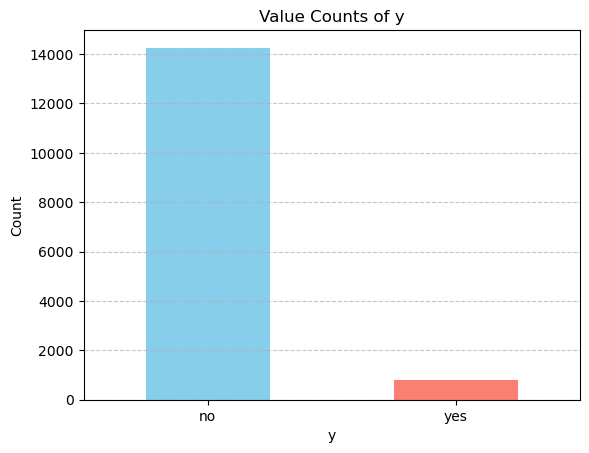

In [29]:
df['y'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Value Counts of y')
plt.xlabel('y')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [31]:
y = y.map({'no': 0, 'yes': 1})
y

0        0
1        0
2        0
3        0
4        0
        ..
41129    0
41136    0
41155    0
41166    1
41171    1
Name: y, Length: 15044, dtype: int64

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [34]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [39]:
#                Predicted
#              |  No   |  Yes
# Actual  ---------------------
#    No       |  TN   |  FP
#    Yes      |  FN   |  TP
# recall = tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print(f"The recall for this model is {recall:.4f}")

The recall for this model is 0.1355


[[2841   13]
 [ 134   21]]


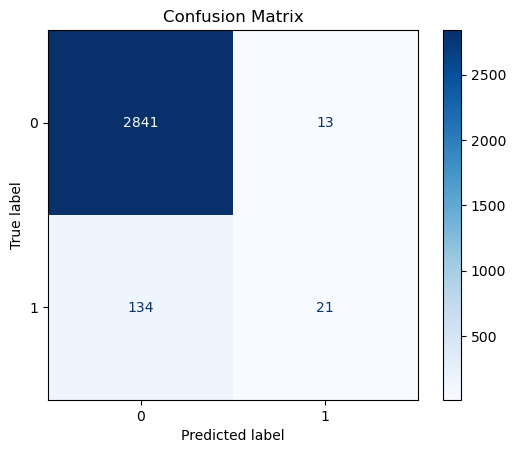

In [41]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues')

# Remove grid
plt.grid(False)  # This removes the grid

plt.title("Confusion Matrix")
plt.show()

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [45]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)


### Problem 9: Score the Model

What is the accuracy of your model?

The recall for this model is 0.0645
[[2845    9]
 [ 145   10]]


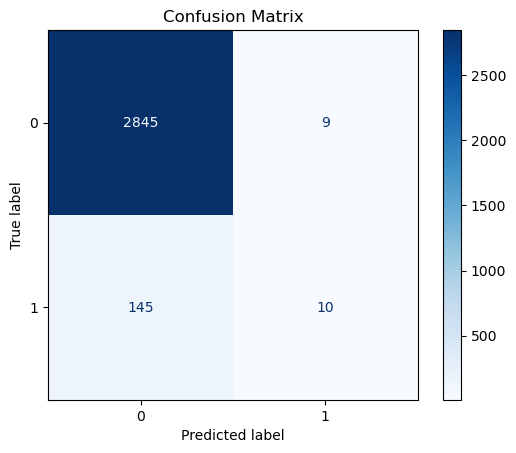

In [48]:
recall = recall_score(y_test, y_pred_lr)
print(f"The recall for this model is {recall:.4f}")

cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

# Plot the cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues')

# Remove grid
plt.grid(False)  # This removes the grid

plt.title("Confusion Matrix")
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [51]:
## assign 90% of CPUs for this job.
import multiprocessing

total_cpus = multiprocessing.cpu_count()
num_cpus = max(1, int(total_cpus * 0.9))  # Ensure at least 1 CPU is used

print(num_cpus)

25


In [53]:

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

with parallel_backend('loky', n_jobs=num_cpus):  # Enable parallel processing
    for name, (model, params) in models.items():
        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            (name, model)
        ])
        
        
        # Fit the model and time it
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        fit_time = time.time() - start_time
        
       
        # Evaluate on training and test sets
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        y_pred = pipeline.predict(X_test)
        test_recall=recall_score(y_test, y_pred)
        
        # Append the results
        results.append([name, fit_time,train_score, test_score,test_recall ])

# Create the results DataFrame , Model	Train Time	Train Accuracy	Test Accuracy
results_df = pd.DataFrame(results, columns=['Model', 'Train Time','Train Accuracy', 'Test Accuracy', 'test_recall'])
#results_df.set_index('model', inplace=True)



In [54]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy,test_recall
0,knn,1.009453,0.953885,0.951147,0.135484
1,logisticregression,1.256394,0.949481,0.948820,0.064516
2,svc,9.391710,0.952638,0.952144,0.135484
3,decisiontreeclassifier,0.326218,0.999086,0.899634,0.206452


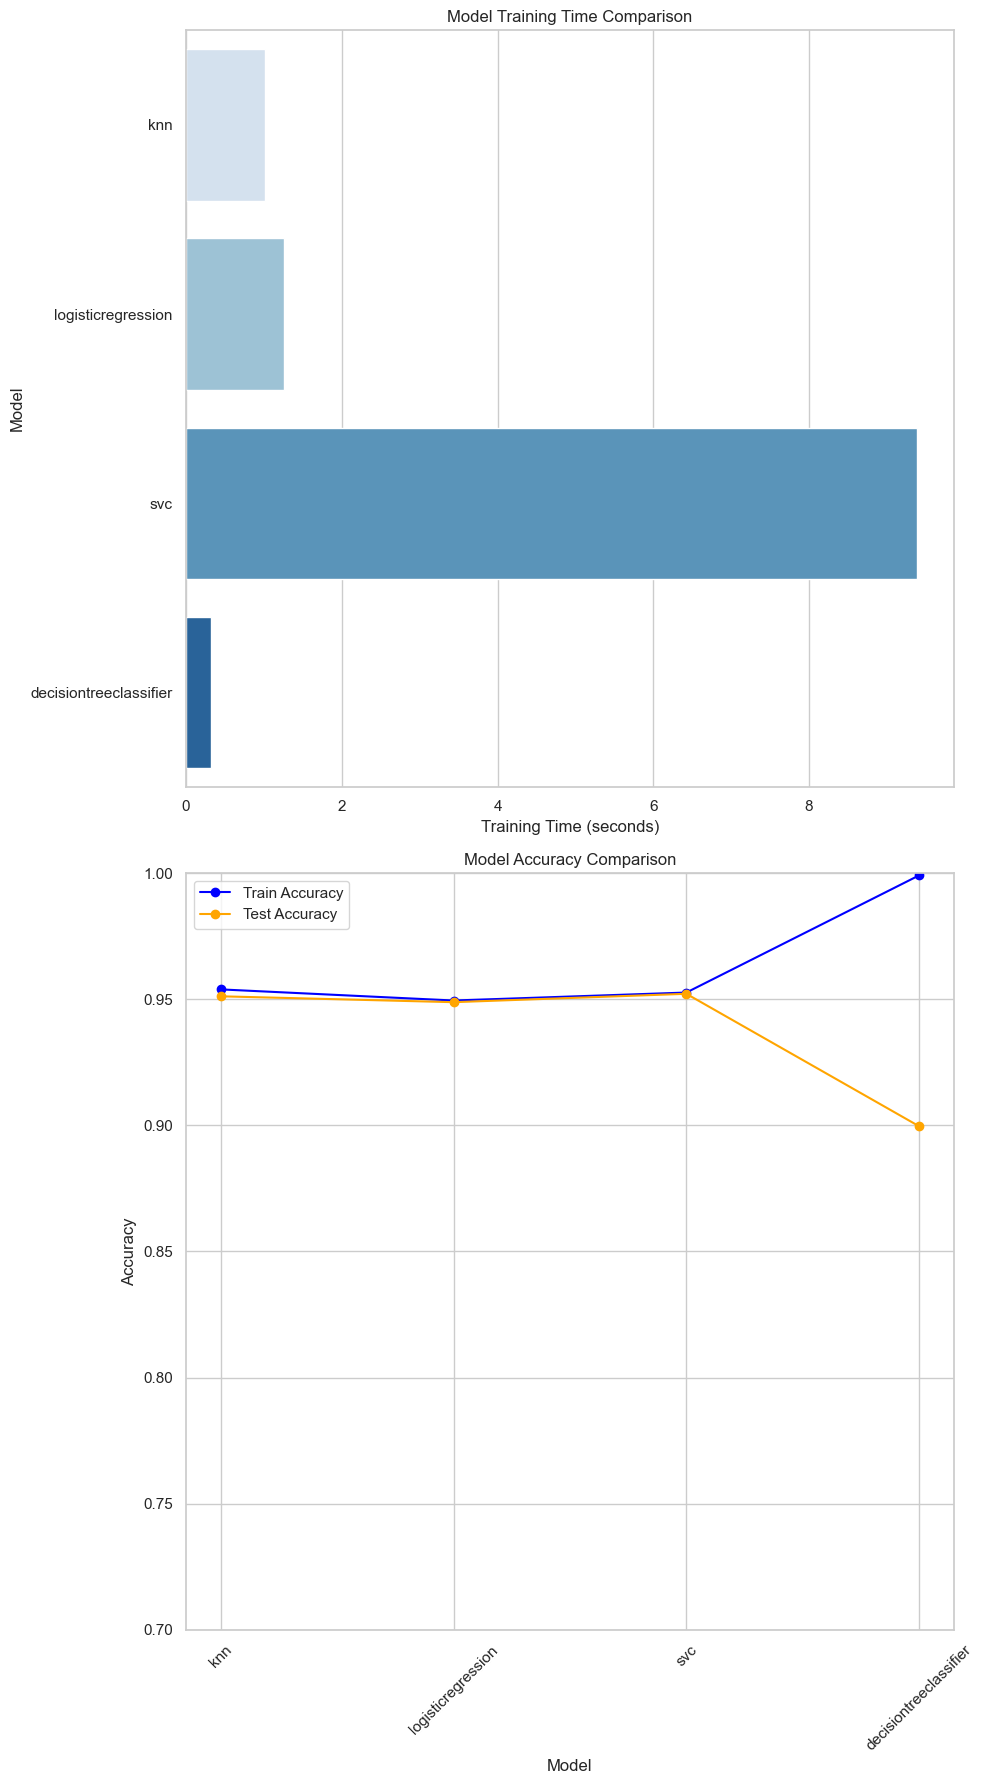

In [57]:
## plot accuracy
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 18))

# Plot for Train Time
sns.barplot(x='Train Time', y='Model', hue='Model', data=results_df, ax=axs[0], palette='Blues', legend=False)

axs[0].set_title('Model Training Time Comparison')
axs[0].set_xlabel('Training Time (seconds)')
axs[0].set_ylabel('Model')

# Plot training accuracy
plt.plot(results_df['Model'], results_df['Train Accuracy'], marker='o', label='Train Accuracy', color='blue')

# Plot testing accuracy
plt.plot(results_df['Model'], results_df['Test Accuracy'], marker='o', label='Test Accuracy', color='orange')

# Adding titles and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)  # Set y-axis limits for clarity
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.grid(True)  # Add grid for easier reading
plt.legend()  # Add legend

# Adjust layout
plt.tight_layout()
plt.show()


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [60]:
# should we keep the gender feature? Why or why not?

## we can compare the accept rate in male and female. The PDF article says no big difference, 11% VS 12%, so the sex column is discarded to reduce computation time.
print('I think it is OK to discard gender feature for this campaign purpose because accept rate is about the same.')

# # For male
# print("Results for male:")
# print(df[df['sex'] == 'Male']['y'].value_counts(normalize=True))

# # For female
# print("\nResults for female:")
# print(df[df['sex'] == 'Female']['y'].value_counts(normalize=True))


I think it is OK to discard gender feature for this campaign purpose because accept rate is about the same.


In [66]:
## GRID SEARCH

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_results = []

print(f"Running the job with CPUS= {num_cpus:d}")
with parallel_backend('loky', n_jobs=num_cpus):  # Enable parallel processing
    for name, (model, params) in models.items():
        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            (name, model)
        ])
        
        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
        ##grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='recall')
        
        # Fit the model and time it
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
        
        # Get the best estimator
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluate on training and test sets
        train_score = best_model.score(X_train, y_train)
        test_score = best_model.score(X_test, y_test)
        y_pred = grid_search.predict(X_test)
        test_recall=recall_score(y_test, y_pred)
    
        # Append the results
        grid_results.append([name, fit_time,train_score, test_score,test_recall, best_params])

# Create the results DataFrame , Model	Train Time	Train Accuracy	Test Accuracy
gridresults_df = pd.DataFrame(grid_results, columns=['Model', 'Train Time','Train Accuracy', 'Test Accuracy','test_recall','Best Params'])
gridresults_df

Running the job with CPUS= 25


,Model,Train Time,Train Accuracy,Test Accuracy,test_recall,Best Params
0,knn,0.982129,0.953885,0.951147,0.135484,{'knn__n_neighbors': 5}
1,logisticregression,0.971811,0.949564,0.948820,0.064516,{'logisticregression__C': 10}
2,svc,105.763557,0.952638,0.952144,0.135484,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
3,decisiontreeclassifier,2.063016,0.954300,0.954470,0.180645,{'decisiontreeclassifier__max_depth': 5}


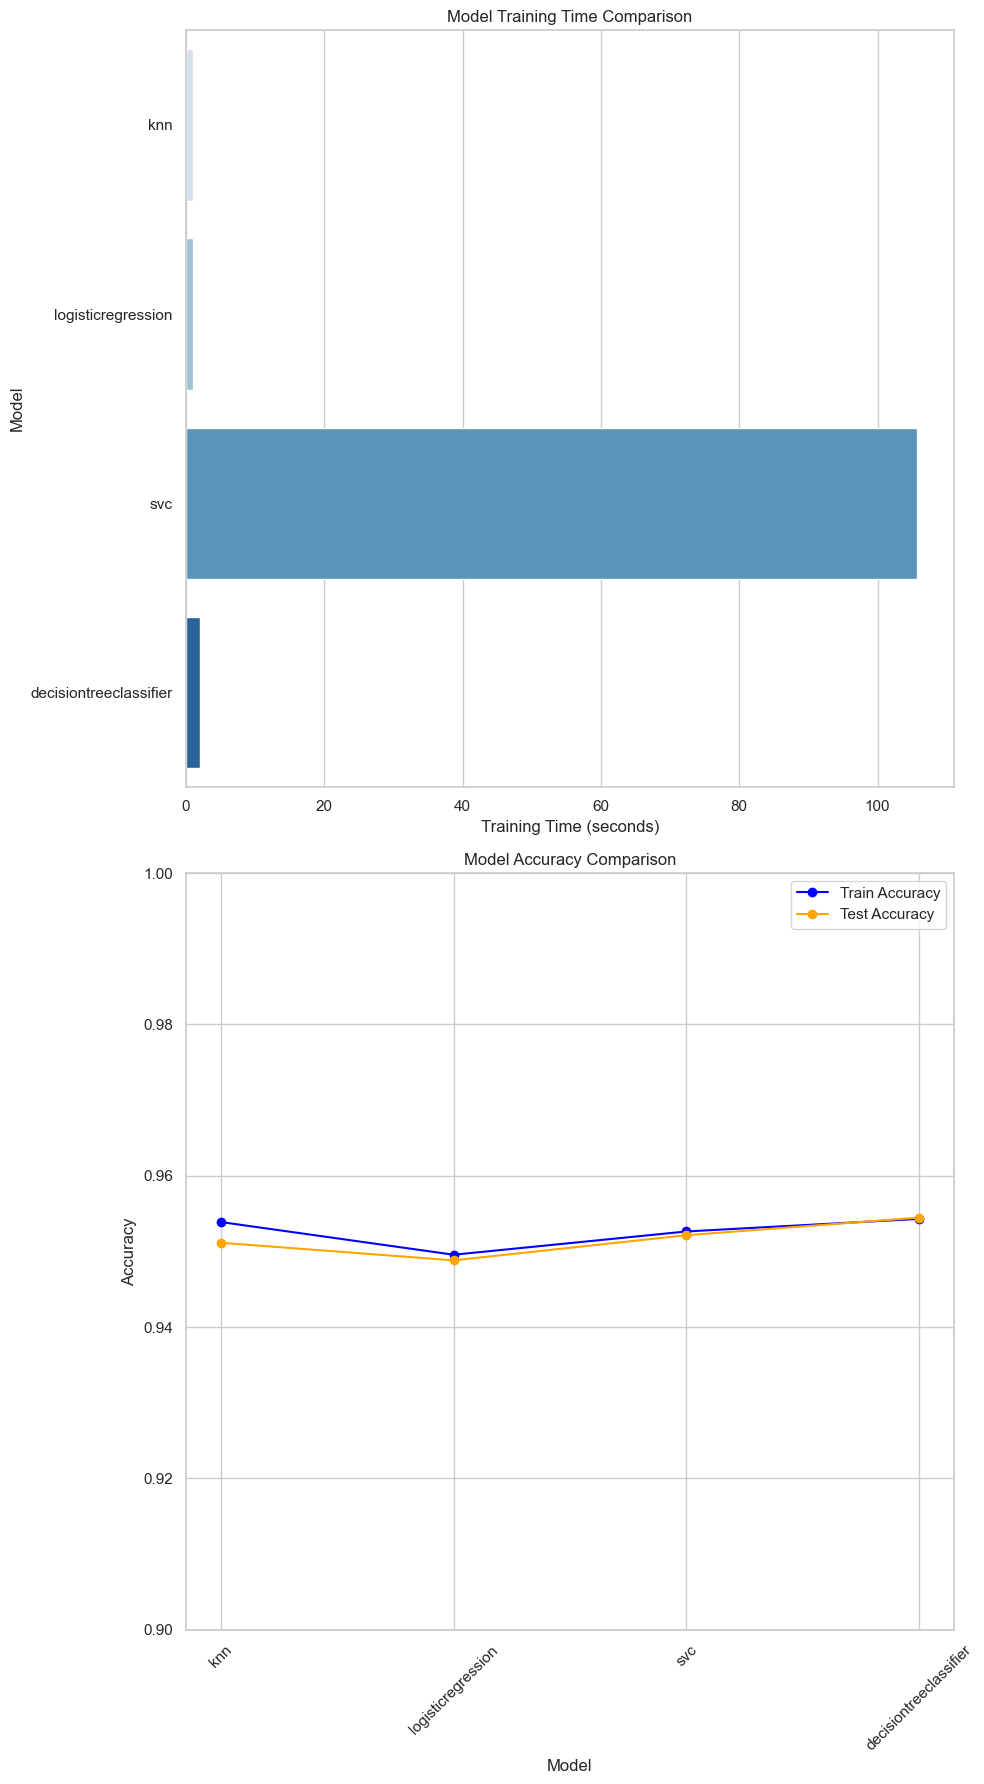

In [76]:
## plot accuracy
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 18))

# Plot for Train Time
sns.barplot(x='Train Time', y='Model', hue='Model', data=gridresults_df, ax=axs[0], palette='Blues')

axs[0].set_title('Model Training Time Comparison')
axs[0].set_xlabel('Training Time (seconds)')
axs[0].set_ylabel('Model')

# Plot training accuracy
plt.plot(results_df['Model'], gridresults_df['Train Accuracy'], marker='o', label='Train Accuracy', color='blue')

# Plot testing accuracy
plt.plot(results_df['Model'], gridresults_df['Test Accuracy'], marker='o', label='Test Accuracy', color='orange')

# Adding titles and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1)  # Set y-axis limits for clarity
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.grid(True)  # Add grid for easier reading
plt.legend()  # Add legend

# Adjust layout
plt.tight_layout()
plt.show()

In [78]:
## Adjust your performance metric . Since Recall are all zero, we can only evaluate on accuracy.
## consider the computation time, lets see which one behaviours the best for the metric, accuracy/time

gridresults_df['accuracy_time']=gridresults_df['Test Accuracy']/gridresults_df['Train Time']
gridresults_df


,Model,Train Time,Train Accuracy,Test Accuracy,test_recall,Best Params,accuracy_time
0,knn,0.982129,0.953885,0.951147,0.135484,{'knn__n_neighbors': 5},0.968454
1,logisticregression,0.971811,0.949564,0.948820,0.064516,{'logisticregression__C': 10},0.976343
2,svc,105.763557,0.952638,0.952144,0.135484,"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.009003
3,decisiontreeclassifier,2.063016,0.954300,0.954470,0.180645,{'decisiontreeclassifier__max_depth': 5},0.462657


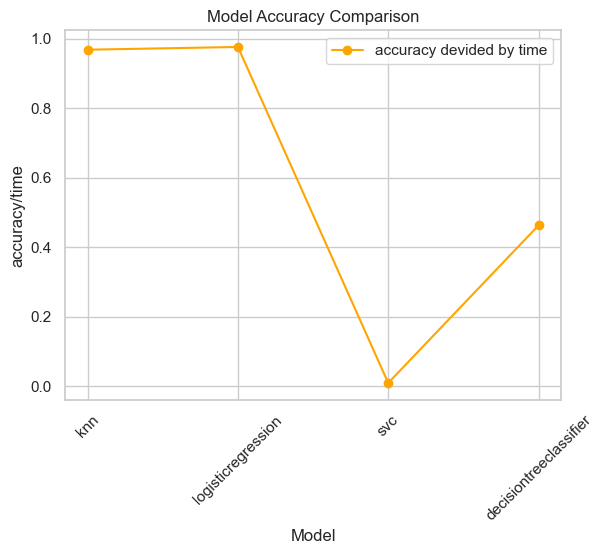

In [80]:
# Plot testing accuracy
plt.plot(gridresults_df['Model'], gridresults_df['accuracy_time'], marker='o', label='accuracy devided by time', color='orange')

# Adding titles and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('accuracy/time')
#plt.ylim(0.9, 1)  # Set y-axis limits for clarity
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.grid(True)  # Add grid for easier reading
plt.legend()  # Add legend

In [82]:
## run the model with parallism (multiple CPUs)
# Get 90% of available CPUs

import multiprocessing

total_cpus = multiprocessing.cpu_count()
num_cpus = max(1, int(total_cpus * 0.9))  # Ensure at least 1 CPU is used


with parallel_backend('loky', n_jobs=num_cpus):  # Enable parallel processing
    print(f"Running the job with CPUS= {num_cpus:d}")

Running the job with CPUS= 25


The train_score for this model is 0.9543
The test_score for this model is 0.9528
The recall for this model is 0.1806
[[2839   15]
 [ 127   28]]


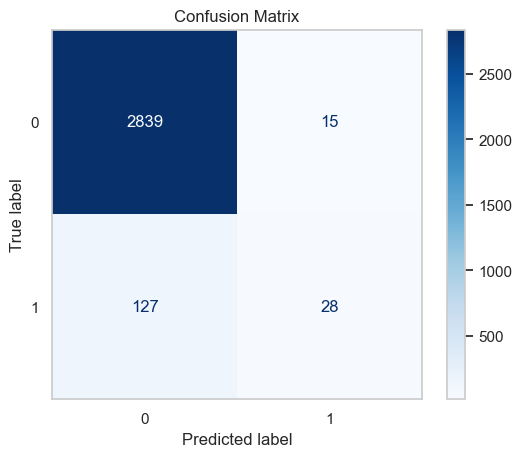

In [92]:
## results from the best model, decision tree

pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(max_depth=5))
])

# Fit the model and time it
start_time = time.time()
pipeline_dt.fit(X_train, y_train)
fit_time = time.time() - start_time

y_pred_dt = pipeline_dt.predict(X_test)

train_score = pipeline_dt.score(X_train, y_train)
test_score = pipeline_dt.score(X_test, y_test)
recall = recall_score(y_test, y_pred_dt)
print(f"The train_score for this model is {train_score:.4f}")
print(f"The test_score for this model is {test_score:.4f}")
print(f"The recall for this model is {recall:.4f}")

cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

# Plot the cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues')

# Remove grid
plt.grid(False)  # This removes the grid

plt.title("Confusion Matrix")
plt.show()

In [102]:
##Findings:
print("""
1. All knn, decitiontree and logisticregression give high prediction accuracy (around 95%) with less CPU time.
2. DecisionTreeClassifier will be a better choice because it gives the highest recall, meaning less False Negative. We will miss less customers if we try to call the minmila customers.
3. SVC model take the most CPU time, and it gives little bit better prediction accuracy, but the recall score is not as good as decitiontree.
4. decisiontreeclassifier needs grid search to get optimal parameters, otherwise, it is very easy to get overfitting and give poor prediction for test data.

""")


1. All knn, decitiontree and logisticregression give high prediction accuracy (around 95%) with less CPU time.
2. DecisionTreeClassifier will be a better choice because it gives the highest recall, meaning less False Negative. We will miss less customers if we try to call the minmila customers.
3. SVC model take the most CPU time, and it gives little bit better prediction accuracy, but the recall score is not as good as decitiontree.
4. decisiontreeclassifier needs grid search to get optimal parameters, otherwise, it is very easy to get overfitting and give poor prediction for test data.




##### Questions